In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Tokenizer, AutoModel, AutoTokenizer
import torch

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot Resource Usage
## 1.Plot Resource Usage per Second
## 2. Plot Resource Usage per Epoch

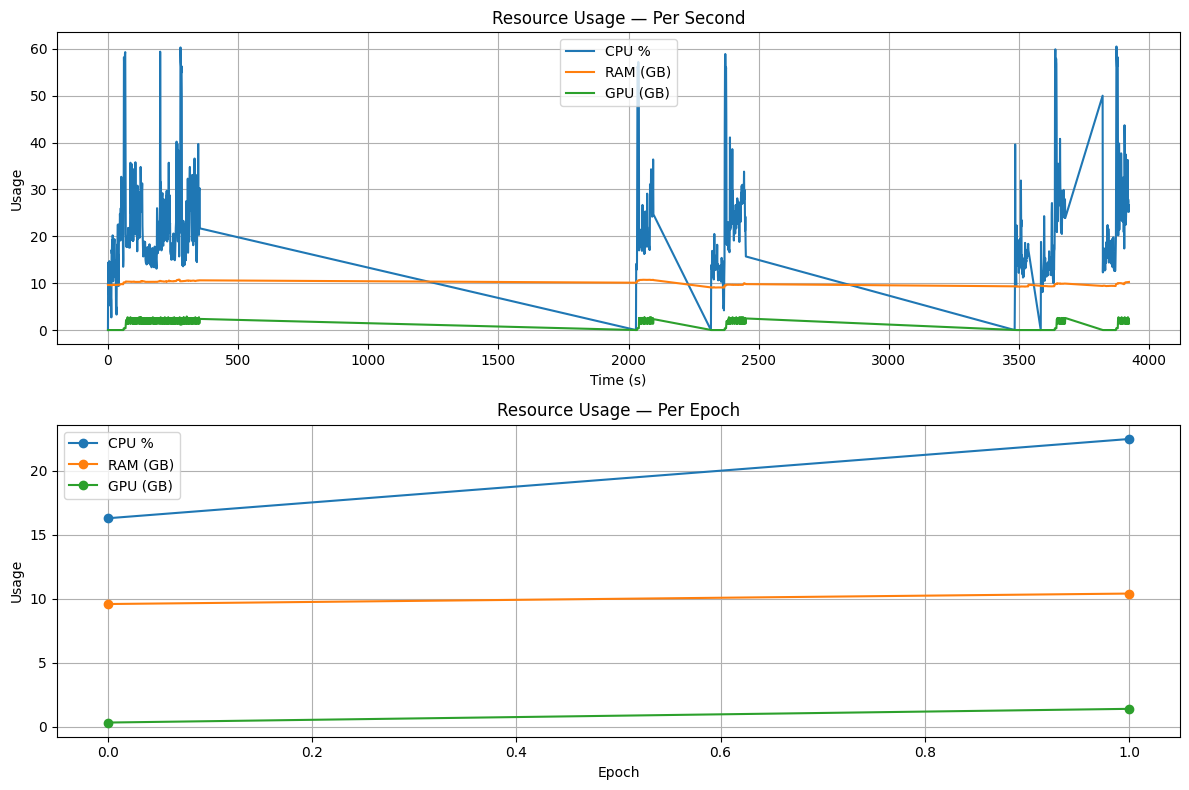

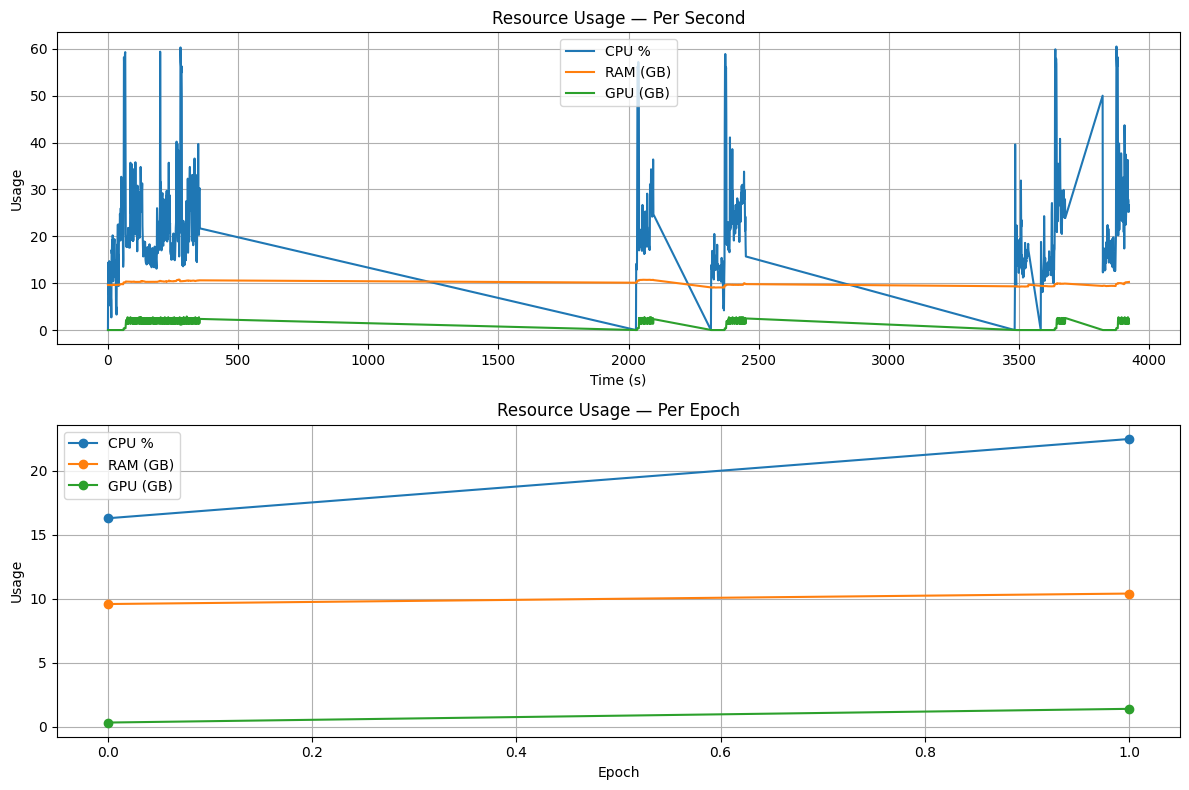

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
from pathlib import Path
import numpy as np

plt.ion()  # enable interactive mode

log_dir = Path("eval_results/resource_usage")
file_sec = log_dir / "usage_seconds.csv"
file_epoch = log_dir / "usage_epochs.csv"

last_epoch_markers = set()

while True:
    try:
        if not file_sec.exists() or not file_epoch.exists():
            time.sleep(1)
            continue

        df_sec = pd.read_csv(file_sec)
        df_epoch = pd.read_csv(file_epoch)

        # Parse epoch_marker like "epoch_3" → 3
        if "epoch_marker" in df_sec.columns:
            df_sec["epoch"] = (
                df_sec["epoch_marker"]
                .fillna("")
                .apply(lambda x: int(x.split("_")[1]) if isinstance(x, str) and x.startswith("epoch_") else np.nan)
            )

        # Drop NaN epochs (rows not inside any epoch)
        df_sec = df_sec.dropna(subset=["time"]).reset_index(drop=True)

        # Normalize timestamps for better visual comparison
        if len(df_sec) == 0:
            time.sleep(1)
            continue

        t0 = min(
            df_sec["time"].iloc[0],
            df_epoch["time"].iloc[0] if len(df_epoch) > 0 else df_sec["time"].iloc[0],
        )
        df_sec["time"] -= t0
        df_epoch["time"] -= t0

        # --- Create figure each loop ---
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        ax_sec, ax_epoch = axes

        # Per-second plot
        ax_sec.plot(df_sec["time"], df_sec["cpu_percent"], label="CPU %")
        ax_sec.plot(df_sec["time"], df_sec["ram_gb"], label="RAM (GB)")
        ax_sec.plot(df_sec["time"], df_sec["gpu_gb"], label="GPU (GB)")
        ax_sec.set_xlabel("Time (s)")
        ax_sec.set_ylabel("Usage")
        ax_sec.set_title("Resource Usage — Per Second")
        ax_sec.legend()
        ax_sec.grid(True)

        # Vertical lines for epoch boundaries
        for epoch in sorted(df_sec["epoch"].dropna().unique()):
            if epoch not in last_epoch_markers:
                first_idx = df_sec[df_sec["epoch"] == epoch].index
                if len(first_idx) > 0:
                    t = df_sec.loc[first_idx[0], "time"]
                    ax_sec.axvline(t, color="gray", linestyle="--", alpha=0.4)
                    ax_sec.text(
                        t,
                        ax_sec.get_ylim()[1] * 0.9,
                        f"epoch_{int(epoch)}",
                        rotation=90,
                        fontsize=8,
                        alpha=0.7,
                    )
                last_epoch_markers.add(epoch)

        # Per-epoch plot
        df_epoch_sorted = df_epoch.sort_values(by="epoch")
        ax_epoch.plot(df_epoch_sorted["epoch"], df_epoch_sorted["cpu_percent"], "o-", label="CPU %")
        ax_epoch.plot(df_epoch_sorted["epoch"], df_epoch_sorted["ram_gb"], "o-", label="RAM (GB)")
        ax_epoch.plot(df_epoch_sorted["epoch"], df_epoch_sorted["gpu_gb"], "o-", label="GPU (GB)")
        ax_epoch.set_xlabel("Epoch")
        ax_epoch.set_ylabel("Usage")
        ax_epoch.set_title("Resource Usage — Per Epoch")
        ax_epoch.legend()
        ax_epoch.grid(True)

        fig.tight_layout()

        # Refresh display
        clear_output(wait=True)
        display(fig)
        plt.pause(0.001)

    except Exception as e:
        # Silently retry on transient read errors
        time.sleep(1)
        continue

    time.sleep(2)


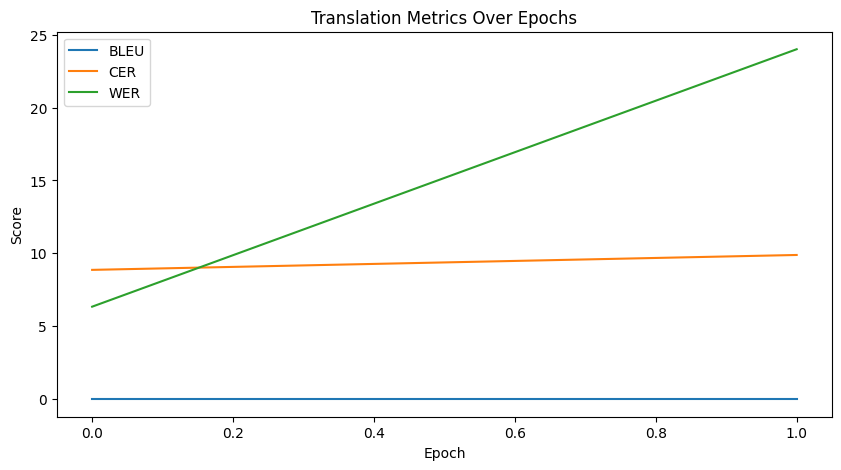

In [21]:
import json
import matplotlib.pyplot as plt

eval_results_file = "eval_results/eval_metrics.json"
with open(eval_results_file, "r") as f:
    all_results = json.load(f)

epochs = [r["epoch"] for r in all_results]
bleu_scores = [r["bleu"] for r in all_results]
cer_scores = [r["cer"] for r in all_results]
wer_scores = [r["wer"] for r in all_results]

plt.figure(figsize=(10,5))
plt.plot(epochs, bleu_scores, label="BLEU")
plt.plot(epochs, cer_scores, label="CER")
plt.plot(epochs, wer_scores, label="WER")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Translation Metrics Over Epochs")
plt.legend()
plt.show()

In [15]:

# --- Attention Visualization ---
import torch
import torch.nn as nn
from config import get_config, get_weights_file_path
from train import get_model, get_ds, greedy_decode
import altair as alt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

config = get_config()
train_dataloader, val_dataloader, vocab_src, vocab_tgt = get_ds(config)
model = get_model(config, vocab_src.get_vocab_size(), vocab_tgt.get_vocab_size()).to(device)

# Load the pretrained weights
model_filename = get_weights_file_path(config, f"25")
try:
    state = torch.load('weights/tmodel_25.pt')
    model.load_state_dict(state['model_state_dict'])
except RuntimeError as e:
    print(f"Error loading model weights: {e}")

def load_next_batch():
    batch = next(iter(val_dataloader))
    encoder_input = batch["encoder_input"].to(device)
    encoder_mask = batch["encoder_mask"].to(device)
    decoder_input = batch["decoder_input"].to(device)

    encoder_input_tokens = [vocab_src.id_to_token(idx) for idx in encoder_input[0].cpu().numpy()]
    decoder_input_tokens = [vocab_tgt.id_to_token(idx) for idx in decoder_input[0].cpu().numpy()]

    assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"

    greedy_decode(
        model, encoder_input, encoder_mask, vocab_src, vocab_tgt, config['seq_len'], device)
    
    return batch, encoder_input_tokens, decoder_input_tokens


def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s" % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s" % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        columns=["row", "column", "value", "row_token", "col_token"],
    )

def get_attn_map(attn_type: str, layer: int, head: int):
    if attn_type == "encoder":
        attn = model.encoder.layers[layer].self_attention_block.attention_scores
    elif attn_type == "decoder":
        attn = model.decoder.layers[layer].self_attention_block.attention_scores
    elif attn_type == "encoder-decoder":
        attn = model.decoder.layers[layer].cross_attention_block.attention_scores
    return attn[0, head].data

def attn_map(attn_type, layer, head, row_tokens, col_tokens, max_sentence_len):
    df = mtx2df(
        get_attn_map(attn_type, layer, head),
        max_sentence_len,
        max_sentence_len,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        .properties(height=400, width=400, title=f"Layer {layer} Head {head}")
        .interactive()
    )

def get_all_attention_maps(attn_type: str, layers: list[int], heads: list[int], row_tokens: list, col_tokens, max_sentence_len: int):
    charts = []
    for layer in layers:
        rowCharts = []
        for head in heads:
            rowCharts.append(attn_map(attn_type, layer, head, row_tokens, col_tokens, max_sentence_len))
        charts.append(alt.hconcat(*rowCharts))
    return alt.vconcat(*charts)

batch, encoder_input_tokens, decoder_input_tokens = load_next_batch()
print(f'Source: {batch["src_text"][0]}')
print(f'Target: {batch["tgt_text"][0]}')
sentence_len = encoder_input_tokens.index("[PAD]")

def combine_all_heads_layers(attn_type, layers):
    combined_layers = []
    for layer in layers:
        if attn_type == "encoder":
            attn = model.encoder.layers[layer].self_attention_block.attention_scores
        elif attn_type == "decoder":
            attn = model.decoder.layers[layer].self_attention_block.attention_scores
        elif attn_type == "encoder-decoder":
            attn = model.decoder.layers[layer].cross_attention_block.attention_scores
        attn = attn.to(device)
        combined_heads = attn.mean(dim=1)  # combine heads in this layer
        combined_layers.append(combined_heads[0])  # batch=1

    stacked = torch.stack(combined_layers, dim=0)
    final_combined = stacked.mean(dim=0)  # average layers
    return final_combined.cpu().data

layers = [0, 1, 2]
heads = [0, 1, 2, 3, 4, 5, 6, 7]

# Encoder Self-Attention
get_all_attention_maps("encoder", layers, heads, encoder_input_tokens, encoder_input_tokens, min(20, sentence_len))

# Encoder Self-Attention
get_all_attention_maps("decoder", layers, heads, decoder_input_tokens, decoder_input_tokens, min(20, sentence_len))

# Encoder Self-Attention
get_all_attention_maps("encoder-decoder", layers, heads, encoder_input_tokens, decoder_input_tokens, min(20, sentence_len))

Using device: cuda
Error loading model weights: PytorchStreamReader failed reading zip archive: failed finding central directory
Source: "Can such abominable pride as his have ever done him good?"
Target: – Pensez-vous qu’un orgueil aussi détestable puisse jamais le porter a bien agir ?


alt.VConcatChart(...)

In [ ]:
# --- Attention Visualization (Final Single Head per Layer) ---
from transformers import GPT2Model, GPT2Tokenizer, AutoModel, AutoTokenizer

import torch
import torch.nn as nn
from Transformer_from_scratch import Transformer
from config import get_config, get_weights_file_path
from train import get_model, get_ds, greedy_decode
import altair as alt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load config, dataset, and model
config = get_config()
train_dataloader, val_dataloader, vocab_src, vocab_tgt = get_ds(config)
model = get_model(config, vocab_src.get_vocab_size(), vocab_tgt.get_vocab_size()).to(device)

# Load pretrained weights
model_filename = get_weights_file_path(config, f"25")
try:
    state = torch.load('weights/tmodel_25.pt')
    model.load_state_dict(state['model_state_dict'])
except RuntimeError as e:
    print(f"Error loading model weights: {e}")

# --- Data loader ---
def load_next_batch():
    batch = next(iter(val_dataloader))
    encoder_input = batch["encoder_input"].to(device)
    encoder_mask = batch["encoder_mask"].to(device)
    decoder_input = batch["decoder_input"].to(device)

    encoder_input_tokens = [vocab_src.id_to_token(idx) for idx in encoder_input[0].cpu().numpy()]
    decoder_input_tokens = [vocab_tgt.id_to_token(idx) for idx in decoder_input[0].cpu().numpy()]

    assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"

    greedy_decode(
        model, encoder_input, encoder_mask, vocab_src, vocab_tgt, config['seq_len'], device)
    
    return batch, encoder_input_tokens, decoder_input_tokens

# --- Helper: Convert matrix to dataframe for Altair ---
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s" % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s" % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        columns=["row", "column", "value", "row_token", "col_token"],
    )

# --- Get attention maps ---
def get_attn_map(attn_type: str, layer: int, head: int):
    if attn_type == "encoder":
        attn = model.encoder.layers[layer].self_attention_block.attention_scores
    elif attn_type == "decoder":
        attn = model.decoder.layers[layer].self_attention_block.attention_scores
    elif attn_type == "encoder-decoder":
        attn = model.decoder.layers[layer].cross_attention_block.attention_scores
    return attn[0, head].data

def attn_map(attn_type, layer, head, row_tokens, col_tokens, max_sentence_len):
    df = mtx2df(
        get_attn_map(attn_type, layer, head),
        max_sentence_len,
        max_sentence_len,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        .properties(height=400, width=400, title=f"Layer {layer} Head {head}")
        .interactive()
    )

# --- New: Single final attention map per layer (average over heads) ---
def get_final_attn_map(attn_type: str, layer: int):
    """Return a single attention map by averaging all heads in a layer."""
    if attn_type == "encoder":
        attn = model.encoder.layers[layer].self_attention_block.attention_scores
    elif attn_type == "decoder":
        attn = model.decoder.layers[layer].self_attention_block.attention_scores
    elif attn_type == "encoder-decoder":
        attn = model.decoder.layers[layer].cross_attention_block.attention_scores
    
    # Average over heads dimension
    return attn[0].mean(dim=0).data  # shape: [seq_len, seq_len]

def final_attn_map(attn_type, layer, row_tokens, col_tokens, max_sentence_len):
    df = mtx2df(
        get_final_attn_map(attn_type, layer),
        max_sentence_len,
        max_sentence_len,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        .properties(height=400, width=400, title=f"Layer {layer} Final Attention")
        .interactive()
    )

# --- Run visualization ---
batch, encoder_input_tokens, decoder_input_tokens = load_next_batch()
print(f'Source: {batch["src_text"][0]}')
print(f'Target: {batch["tgt_text"][0]}')
sentence_len = encoder_input_tokens.index("[PAD]")

layers = [0, 1, 2]  # layers to visualize

# Encoder final attention
for layer in layers:
    final_attn_map("encoder", layer, encoder_input_tokens, encoder_input_tokens, min(20, sentence_len))

# Decoder final attention
for layer in layers:
    final_attn_map("decoder", layer, decoder_input_tokens, decoder_input_tokens, min(20, sentence_len))

# Encoder-Decoder final attention
for layer in layers:
    final_attn_map("encoder-decoder", layer, encoder_input_tokens, decoder_input_tokens, min(20, sentence_len))


Using device: cuda
Error loading model weights: PytorchStreamReader failed reading zip archive: failed finding central directory
Source: Soon after their return, a letter was delivered to Miss Bennet; it came from Netherfield.
Target: Peu apres leur retour, un pli apporté de Netherfield fut remis a Jane qui l’ouvrit aussitôt.


In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
import altair as alt
import pandas as pd

# --- Load GPT-2 model and tokenizer ---
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2Model.from_pretrained(model_name, output_attentions=True)
model.eval()

# --- Choose text input ---
text = "The quick brown fox jumps over the lazy dog."
inputs = tokenizer(text, return_tensors="pt")

# --- Run GPT-2 and get attention outputs ---
with torch.no_grad():
    outputs = model(**inputs)
attentions = outputs.attentions  # tuple of [num_layers x (batch, num_heads, seq_len, seq_len)]

num_layers = len(attentions)
num_heads = attentions[0].size(1)
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

print(f"✅ Got attention maps: {num_layers} layers × {num_heads} heads")

# --- Helper: convert attention tensor → DataFrame for Altair ---
def attention_to_df(attn, layer, head, tokens):
    attn = attn[0, head].detach().cpu()
    rows = []
    for i in range(attn.shape[0]):
        for j in range(attn.shape[1]):
            rows.append({
                "layer": layer,
                "head": head,
                "from_token": f"{i:02d} {tokens[i]}",
                "to_token": f"{j:02d} {tokens[j]}",
                "weight": float(attn[i, j]),
            })
    return pd.DataFrame(rows)

# --- Select one layer and one head to visualize ---
layer = 0
head = 0
df = attention_to_df(attentions[layer], layer, head, tokens)

chart = (
    alt.Chart(df)
    .mark_rect()
    .encode(
        x=alt.X("to_token", sort=None, title="Key (attended to)"),
        y=alt.Y("from_token", sort=None, title="Query (attending token)"),
        color=alt.Color("weight", scale=alt.Scale(scheme="blues")),
        tooltip=["from_token", "to_token", "weight"]
    )
    .properties(title=f"GPT-2 Attention — Layer {layer}, Head {head}", width=400, height=400)
    .interactive()
)

chart


NameError: name 'sample_sentence' is not defined